# VQE Introduction

## Imports

In [1]:
# Imports
import qiskit
from qiskit import IBMQ
import math
import cmath
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy import linalg as la
from scipy import linalg as sla
from IPython.display import clear_output
import time
import pickle
from qiskit.extensions import XGate, UnitaryGate
from qiskit import *
from qiskit.compiler import transpile
import networkx as nx
import importlib
from qiskit.quantum_info.synthesis import two_qubit_cnot_decompose as two_qubit_decomp

## Definitions

In [2]:
## Definitions
pi = np.pi

zero = np.matrix([[1],[0]],dtype=complex)
one  = np.matrix([[0],[1]],dtype=complex)

I = np.matrix([[1,0],[0,1]],dtype=complex)
X = np.matrix([[0,1],[1,0]],dtype=complex)
Y = np.matrix([[0,-1j],[1j,0]],dtype=complex)
Z = np.matrix([[1,0],[0,-1]],dtype=complex) 

swap = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

## Variational Principle

The Variational Quantum Eigensolver (VQE) algorithm is based on the variational principle: The expectation value of a Hamiltonian $H$ in a state $|\psi(\theta)\rangle$ paremetrized by a set of angles $\theta$, is always greater than or equal to the the minimum eigenenergy $E_0$. To see this, let $|n\rangle$ be the eigenstates of $H$, that is:

$$H|n\rangle=E_n|n\rangle$$

We can then expand our state $|\psi(\theta)\rangle$ in terms of said eigenstates

$$ |\psi(\theta)\rangle=\sum_nc_n|n\rangle $$

and plug this into the expectation value to yield

$$
\begin{align}
\langle\psi(\theta)|H|\psi(\theta)\rangle
&=
\sum_{nm}c^*_mc_n\langle m|H|n \rangle
\\
&=
\sum_{nm}c^*_mc_nE_n\langle m|n \rangle
\\
&=
\sum_{nm}\delta_{nm}c^*_mc_nE_n
\\
&=
\sum_{n}|c_n|^2E_n
\\
&\geq
E_0\sum_{n}|c_n|^2
\\
&=
E_0
\end{align}
$$

which implies that we can minimize over the set of angles $\theta$ and arrive at the ground state energy $E_0$:

$$
\min_\theta \ \langle\psi(\theta)|H|\psi(\theta)\rangle
=
E_0
$$

Using this fact, the VQE algorithm goes as follows:

1. Prepare the variational state $|\psi(\theta)\rangle$ on a quantum computer.
2. Measure this circuit in various bases and send these measurements to a classical computer
3. The classical computer post-processess the measurement data to compute the expectation value $\langle\psi(\theta)|H|\psi(\theta)\rangle$
4. The classical computer varies the parameters $\theta$ according to a classical minimization algorithm and sends them back to the quantum computer which runs step 1 again.

This loop continues until the classical optimization algorithm terminates which results in a set of angles $\theta_{\text{min}}$ that characterize the ground state $|\phi(\theta_{\text{min}})\rangle$ and an estimate for the ground state energy $\langle\psi(\theta_{\text{min}})|H|\psi(\theta_{\text{min}})\rangle$.

## Expectation Values

After an ansatz is prepared on a quantum circuit, the expectation value of the Hamiltonian is estimated. A Hamiltonian with $k$ sites is expressed as a sum of Pauli strings:

$$ H = \sum_{n}c_nP_n $$

where $c_n$ are constants and

$$ P_n = \bigotimes_k\sigma_k $$

where $\sigma=X,Y,Z$. Because the expectation value is linear

$$ \langle H \rangle = \langle \sum_{n}c_nP_n \rangle =  \sum_{n} c_n \langle P_n \rangle  $$

we simply need to know how to take the expectation value of strings of Paulis. Let's start with a single Pauli and begin with $Z$. The expectation value of $Z$ in state $|\psi\rangle$ can be written in terms of probabilities as

$$
\begin{align*}
E_{\psi}(Z)
&=\langle \psi|Z|\psi \rangle \\
&=\langle \psi|\left(|0\rangle\langle0|-|1\rangle\langle1|\right)|\psi\rangle \\
&=\langle \psi|0 \rangle \langle 0|\psi \rangle-\langle \psi|1 \rangle \langle 1|\psi \rangle  \\
&=|\langle 0|\psi \rangle|^2-|\langle 1|\psi \rangle|^2  \\
&=P(\psi\to0)-P(\psi\to1)
\end{align*}
$$

where $P(\psi\to x)$ is the probability that state $|\psi\rangle$ is measured to be $|0\rangle$. Thus, one does nothing to the qubit in state $|\psi\rangle$, as shown below:

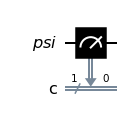

In [16]:
# expectation value of Z circuit
q = QuantumRegister(1,'psi')
c = ClassicalRegister(1,'c')
circ = QuantumCircuit(q,c)

circ.measure(q,c)

circ.draw('mpl')

which means prepare the state $|\psi\rangle$ and measures. One does this over and over, counting $C_0$, the number of times one measures $0$ and $C_1$, the number of times one measures $1$. From these numbers, on can estimate the probability of measuring $0$ and $1$ as 
\begin{align*}
P(\psi\to0)&=\frac{C_0}{C_0+C_1} \\
P(\psi\to1)&=\frac{C_1}{C_0+C_1}
\end{align*}
The more measurements made, the more accurate the prediction becomes. To find the expectation value of $Z$, one simply subtracts the probabilities as above:
\begin{align*}
E_{\psi}(Z) 
&=
P(\psi\to0)-P(\psi\to1)
\\
&=
\frac{C_0-C_1}{C_0+C_1}
\end{align*}

We now turn to finding the expecation value of $X$. To do so, we are going to rotate our computation basis.
Recalling the identity $X=HZH$ allows us to write

$$
\begin{align*}
E_{\psi}(X)
&=\langle \psi|X|\psi \rangle \\
&=\langle \psi|HZH|\psi \rangle \\
&=\langle H\psi|Z|H\psi \rangle \\
&=P(H\psi\to0)-P(H\psi\to1)
\end{align*}
$$

Thus, one appends a Hadamard gate $H$ to the qubit in state $|\psi\rangle$, as shown below:

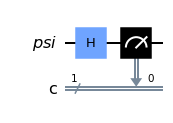

In [18]:
# expectation value of X circuit
q = QuantumRegister(1,'psi')
c = ClassicalRegister(1,'c')
circ = QuantumCircuit(q,c)

circ.h(q[0])
circ.measure(q,c)

circ.draw('mpl')

##### Problem 3

Finally, we turn to the expectation value of $Y$. Use the identity $Y=SXS^{\dagger}$ to prove that

$$ 
E_{\psi}(Y)
=
P(HS^\dagger\psi\to0)-P(HS^\dagger\psi\to1) 
$$

Thus, one appends $HS^\dagger$ to the qubit in state $|\psi\rangle$, as shown below:

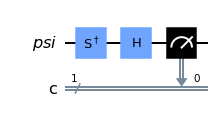

In [22]:
# expectation value of X circuit
q = QuantumRegister(1,'psi')
c = ClassicalRegister(1,'c')
circ = QuantumCircuit(q,c)

circ.sdg(q[0])
circ.h(q[0])
circ.measure(q,c)

circ.draw('mpl')

Summarizing, to rotate bases, one uses the basis rotator $B_\sigma$ which is defined for each Pauli-gate $\sigma$ to be

\begin{align}
B_{\sigma} \equiv
\begin{cases}
H, & \text{if} \ \sigma = X \\
HS^{\dagger}, & \text{if} \ \sigma = Y \\
I, & \text{if} \ \sigma = Z \\
\end{cases}
\end{align}

Note the following identity of the basis rotator

\begin{align}
B^\dagger_\sigma Z B_\sigma = \sigma
\end{align}

which follows from the identities $HZH=X$ and $SXS^\dagger=Y$.

We now extend to a string of Paulis. To get some intution, consider the expectation value of $ZZ$ (since we always seem to end up just taking expectation values of $Z$):

$$
\begin{align}
E(ZZ) 
&= 
\langle\psi|ZZ|\psi\rangle
\\
&=
\langle\psi|(|0\rangle\langle0|-|1\rangle\langle1|)(|0\rangle\langle0|-|1\rangle\langle1|)|\psi\rangle
\\
&=
\langle\psi|(|00\rangle\langle00|-|01\rangle\langle01|-|10\rangle\langle10|+|11\rangle\langle11|)|\psi\rangle
\\
&=
P(\psi\to00)-P(\psi\to01)-P(\psi\to10)+P(\psi\to11)
\end{align}
$$

First note that any Pauli string $P=\bigotimes_k\sigma_k$ can be rewritten as a the expecation value of a string of $Z$ operators by using the basis rotators above:

$$
\begin{align}
\langle\psi|P|\psi\rangle
&=
\langle\psi|\bigotimes_k\sigma_k|\psi\rangle
\\
&=
\langle\psi|\bigotimes_k(B^\dagger_{\sigma_k} Z B_{\sigma_k})|\psi\rangle
\\
&=
\langle\psi|(\bigotimes_k B^\dagger_{\sigma_k})(\bigotimes_k Z)(\bigotimes_kB_{\sigma_k})|\psi\rangle
\\
&=
\langle\bigotimes_k B^\dagger_{\sigma_k}\psi|\bigotimes_k Z|\bigotimes_kB_{\sigma_k}\psi\rangle
\end{align}
$$

Defining $ |\phi\rangle = |\bigotimes_kB_{\sigma_k}\psi\rangle $ we can see that the expectation value is given by

$$
\begin{align}
\langle\psi|P|\psi\rangle
&=
\langle\phi|\bigotimes_k Z|\phi\rangle 
\\
&=
\langle\phi|\bigotimes_k(\sum_{x\in\{0,1\}}(-1)^x|x \rangle\langle x|)|\phi\rangle 
\\
&=
\sum_{x\in\{0,1\}^n}(-1)^{h(x)}|\langle x|\phi\rangle|^2
\\
&=
\sum_{x\in\{0,1\}^n}(-1)^{h(x)}P(\phi \to x)
\end{align}
$$

where $h(x)$ is the Hamming weight of $x$, defined as the number of 1s in the bit string. For example, the Hamming weight of $x=01101$ is 3. Thus we see that we simply take a linear combination of the probabilities of measuring each possible bit string where bit strings with an even (odd) Hamming weight have a +1 (-1) coefficient, respectively. 

Finally, we deal with the case where our Pauli string containts identities $I$ by noting that 
$I= |0\rangle\langle0|+|1\rangle\langle1|$ and thus doesn't contribute any minus signs. Therefore, we simply modify the previous equation by replacing $h(x)$ with $h_P(x)$ which counts the number of 1s in the bitstring $x$, excluding the bits whose position shares the same index as the position of an identity in the Pauli string $P$.

## Hamiltonian

We will now apply VQE to a simple Hamiltonian:

$$ H=\frac{A}{2}\left(X_0X_1+Y_0Y_1\right) $$

##### Problem 1:
Next we'll create a set of functions that will allow us to estimate the expectation value of this Hamiltonian on a quantum computer. First, we will create functions that rotate the computational basis to the $XX$ and $YY$ basis:

In [37]:
## circuit to rotate to XX basis
def rotate_to_xx(circ):
    
    circ.h(circ.qubits[0])
    circ.h(circ.qubits[1])
    
    return circ

## circuit to rotate to YY basis
def rotate_to_yy(circ):
    
    ### YOUR CODE HERE ###
    
    return circ

Next we will create a function that estimates the expectation value from the counts

In [60]:
## expecation value
def counts_to_exp(counts):
    
    # populate empty counts with 0
    for bs in ['00','01','10','11']:
        if bs not in counts:
            counts[bs] = 0
    
    # numerator of expecation value
    num = counts['00'] - counts['01'] - counts['10'] + counts['11'] 
    
    # denominator of expectation value
    den = counts['00'] + counts['01'] + counts['10'] + counts['11'] 
    
    # expectation value
    exp = num/den
    
    return exp

### Ansatz

To determine a good ansatz for this Hamiltonian, let's look at it in matrix form. Below we define a function that returns the Hamiltonian matrix for a given input A. Run the function for A=1 to see the form of the Hamiltonian matrix:

In [28]:
# Hamltonian matrix
def H(A):
    
    hamiltonian = (A/2)*(np.kron(X,X)+np.kron(Y,Y))
    
    return hamiltonian

In [115]:
# see Hamiltonian matrix
print('H =')
print(H(1))

H =
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


From the matrix above, we can see that the Hamiltonian destroys two states

$$ H|00\rangle = 0 $$
$$ H|00\rangle = 0 $$

and swaps the other two

$$ H|10\rangle = A|01\rangle $$
$$ H|01\rangle = A|10\rangle $$

This motivates the following ansatz

$$ |\psi(\phi)\rangle = \frac{1}{\sqrt{2}}\left(|10\rangle+e^{i\phi}|01\rangle\right) $$

Why?

##### Problem 2: Verify that the ansatz is an eigenfunction of the Hamiltonian by showing that

$$ \langle\psi(\phi)|H|\psi(\phi)\rangle = A\cos(\phi) $$

Now we will create a quantum circuit that prepares the ansatz:

##### Problem 3: 

Create a quantum circuit that prepares the ansatz

In [53]:
def ansatz(phi):
    
    # create two-qubit quantum register
    q = QuantumRegister(2,'q')
    c = ClassicalRegister(2,'c')

    # initialize quantum circuit
    circ = QuantumCircuit(q,c)

    # add gates to create ansatz
    
    ### YOUR CODE HERE ###
    
    # return circuit
    return circ

Visualize your circuit below

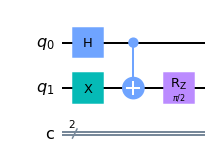

In [56]:
phi = pi/2

circ = ansatz(phi)

circ.draw('mpl')

Verify your circuit by getting the statevector below

In [50]:
psi = execute(circ, BasicAer.get_backend('statevector_simulator')).result().get_statevector()
print(np.round(psi,2))

[0. +0.j  0.5-0.5j 0.5+0.5j 0. +0.j ]


## VQE

We will now apply VQE to our simple example. First we must define a function that estimates the expecation value of $\langle\psi(\phi)|H|\psi(\phi)\rangle$:

In [137]:
# expecation value of the Hamiltonian
def exp_of_H(phi,constants):
    
    constants[0] = A
    constants[1] = shots
    
    # prepare ansatz
    circ = ansatz(phi)
    
    # get rotated circuits
    circ_xx = rotate_to_xx(circ)
    circ_yy = rotate_to_yy(circ)
    
    # measure each circuit
    circ_xx.measure(circ_xx.qubits,circ_xx.clbits)
    circ_yy.measure(circ_xx.qubits,circ_yy.clbits)
    
    # get the counts of each rotated circuit
    sampler = qiskit.Aer.get_backend('qasm_simulator')
    counts_xx = qiskit.execute(circ_xx, sampler, shots=shots).result().get_counts(circ_xx)
    counts_yy = qiskit.execute(circ_yy, sampler, shots=shots).result().get_counts(circ_yy)
    
    # get the expectation value from each set of counts
    exp_xx = counts_to_exp(counts_xx)
    exp_yy = counts_to_exp(counts_yy)
    
    # get the expectation value of the Hamiltonian
    exp = (A/2)*(exp_xx + exp_yy)
    
    # return the expectation value of the Hamiltonian
    return exp

Before running the full VQE algorithm, we will visualize the search space by plotting the estimated expectation value vs the exact expectation value for multiple values of $\phi$:

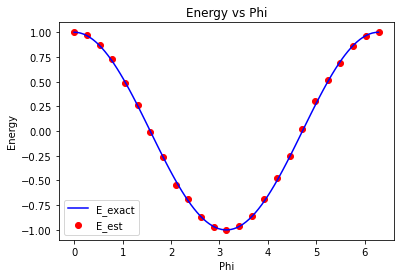

In [138]:
## Visualize search space

# inputs
A = 1
shots = 2**10
n = 25 # number of instances of phi
phi_est_list = np.linspace(0,2*pi,n)
phi_exact_list = np.linspace(0,2*pi,100)

# initialize list of expectation values
exp_est_list = []
exp_exact_list = []

# loop through phi_list
for phi in phi_est_list:
    constants = [A,shots]
    exp_est_list.append(exp_of_H(phi,constants))
    
# get exact energy
for phi in phi_exact_list:
    exp_exact_list.append(np.cos(phi))
    
# plot
plt.scatter(phi_est_list,exp_est_list,color='r',label='E_est')
plt.plot(phi_exact_list,exp_exact_list,color='b',label='E_exact')
plt.xlabel('Phi')
plt.ylabel('Energy')
plt.title('Energy vs Phi')
plt.legend()
plt.show()

From this we can see that $\phi=\pi/2$ minimizes the energy. Finally, we'll run VQE. The last step missing is to create a function that runs a classical optimization algorithm:

In [163]:
def vqe(phi,A,shots,method):
    
    # define constants
    constants = [A,shots]
    
    # get E_true
    e_vec, e_val = la.eig(H(A))
    E_true = np.round(np.real(min(e_vec)),10)
    
    # callback function for visualization of minimization
    diff = []
    def callback(x):
        diff.append(exp_of_H(x,constants)-E_true)
        itr = np.linspace(1,len(diff),len(diff))
        plt.xlabel('Iterations')
        plt.ylabel('Energy Difference')
        plt.title('Energy Difference vs Iterations')
        plt.plot(itr,diff)
        clear_output(wait=True)
        plt.show()
    
    # optimize
    opt = sp.optimize.minimize(exp_of_H, x0=phi, args=constants, method=method, callback=callback)
    
    # get phi_min
    phi_min = opt.x
    
    # get ground state estimate
    E_est = exp_of_H(phi_min,constants)
    
    # return ground state estimate and exact ground state
    return E_est, E_true

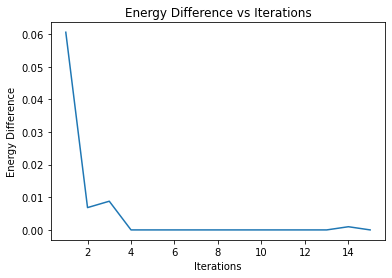

E_estimate = -1.0
E_exact =  -1.0
E_error = 0.0


In [164]:
phi = np.random.uniform(0,2*pi)
A = 1
constants = [A,shots]
method = 'Nelder-Mead'

# run vqe
E_est, E_ext = vqe(phi,A,shots,method)

# print results
print('E_estimate =',E_est)
print('E_exact = ',E_ext)
print('E_error =',abs((E_est-E_ext)/E_ext))

## Challenge

Let's extend the Hamiltonian to three qubits:

$$
H = \frac{A}{2}[(X_0X_1+Y_0Y_1)+(X_1X_2+Y_1Y_2)+(X_2X_0+Y_2Y_0)]
$$

##### Problem 4: 
Prove that the following ansatz is an eigenstate of $H$:

$$
|\psi(\theta,\phi)\rangle
=
\frac{1}{\sqrt{3}}\left(|100\rangle+e^{i\theta}|010\rangle+e^{i\phi}|001\rangle\right)
$$

##### Problem 5:

Create this ansatz with a quantum circuit and run VQE for this Hamiltonian.

## Solutions

### Problem 1

In [38]:
## circuit to rotate to YY basis
def rotate_to_yy(circ):
    
    circ.sdg(circ.qubits[0])
    circ.h(circ.qubits[0])
    
    circ.sdg(circ.qubits[1])
    circ.h(circ.qubits[1])
    
    return circ

### Problem 2

$$
\begin{align}
\langle\psi(\phi)|H|\psi(\phi)\rangle
&=
\frac{A}{4}\left(\langle10|+e^{-i\phi}\langle01|\right)
\left(X_0X_1+Y_0Y_1\right)
\left(|10\rangle+e^{i\phi}|01\rangle\right)
\\
&=
\frac{A}{2}\left(\langle10|+e^{-i\phi}\langle01|\right)
\left(|01\rangle+e^{i\phi}|10\rangle\right)
\\
&=
\frac{A}{2}\left(e^{i\phi}+e^{-i\phi}\right)
\\
&=
A\cos(\phi)
\end{align}
$$

### Problem 3

In [55]:
def ansatz(phi):
    
    # create two-qubit quantum register
    q = QuantumRegister(2,'q')
    c = ClassicalRegister(2,'c')

    # initialize quantum circuit
    circ = QuantumCircuit(q,c)

    # add gates to create ansatz
    
    circ.h(q[0])
    circ.x(q[1])
    circ.cx(q[0],q[1])
    circ.rz(phi,q[1])
    
    # return circuit
    return circ

### Problem 4

$$
\begin{align}
\langle\psi(\theta,\phi)|H|\psi(\theta,\phi)\rangle
&=
\frac{A}{6}
\left(\langle100|+e^{-i\theta}\langle010|+e^{-i\phi}\langle001|\right)
[(X_0X_1+Y_0Y_1)+(X_1X_2+Y_1Y_2)+(X_2X_0+Y_2Y_0)]
\left(|100\rangle+e^{i\theta}|010\rangle+e^{i\phi}|001\rangle\right)
\\
&=
\frac{A}{6}
\left(\langle100|+e^{-i\theta}\langle010|+e^{-i\phi}\langle001|\right)
\left((|010\rangle+|001\rangle)+e^{i\theta}(|100\rangle+|001\rangle)+e^{i\phi}(|010\rangle+|100\rangle)\right)
\\
&=
\frac{A}{6}
\left[
\left(e^{i\theta}+e^{-i\theta}\right)
+
\left(e^{i\phi}+e^{-i\phi}\right)
+
\left(e^{i(\phi-\theta)}+e^{-i(\phi-\theta)}\right)
\right]
\\
&=
\frac{A}{3}\left[\cos(\theta)+\cos(\phi)+\cos(\theta-\phi)\right]
\end{align}
$$